# Age related Macular Degeneration Myopia Prediction Model

### Step 1: Import libraries

In [1]:
import os, glob, cv2, random
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from sklearn.model_selection import train_test_split

C:\Users\rocky\AppData\Local\Temp\ipykernel_35852\852393205.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### Step 2: Read dataset

In [2]:
df = pd.read_csv("C:/Users/rocky/OneDrive/Desktop/Ocular-Disease-Recognition/data/full_df.csv")
df.head(3)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg


### Step 3. Extracting Age related macular degeneration & Normal information from the dataset

##### Age related macular degeneration images

In [3]:
def has_age(text):
    if "age" in text:
        return 1
    else:
        return 0

In [4]:
df["left_age"] = df["Left-Diagnostic Keywords"].apply(lambda x: has_age(x))
df["right_age"] = df["Right-Diagnostic Keywords"].apply(lambda x: has_age(x))

In [6]:
left_age = df.loc[(df.A ==1) & (df.left_age == 1)]["Left-Fundus"].values
left_age[:15]

array(['43_left.jpg', '48_left.jpg', '53_left.jpg', '55_left.jpg',
       '102_left.jpg', '126_left.jpg', '136_left.jpg', '152_left.jpg',
       '158_left.jpg', '162_left.jpg', '164_left.jpg', '168_left.jpg',
       '178_left.jpg', '210_left.jpg', '212_left.jpg'], dtype=object)

In [7]:
right_age = df.loc[(df.A ==1) & (df.right_age == 1)]["Right-Fundus"].values
right_age[:15]

array(['43_right.jpg', '48_right.jpg', '53_right.jpg', '55_right.jpg',
       '71_right.jpg', '102_right.jpg', '126_right.jpg', '152_right.jpg',
       '153_right.jpg', '158_right.jpg', '160_right.jpg', '162_right.jpg',
       '164_right.jpg', '168_right.jpg', '178_right.jpg'], dtype=object)

In [8]:
print("Number of images in left age-related macular: {}".format(len(left_age)))
print("Number of images in right age-related macular: {}".format(len(right_age)))

Number of images in left age-related macular: 267
Number of images in right age-related macular: 285


##### Normal images

In [9]:
left_normal = df.loc[(df.A ==0) & (df["Left-Diagnostic Keywords"] == "normal fundus")]["Left-Fundus"].sample(276,random_state=42).values
right_normal = df.loc[(df.A ==0) & (df["Right-Diagnostic Keywords"] == "normal fundus")]["Right-Fundus"].sample(276,random_state=42).values

In [10]:
age = np.concatenate((left_age,right_age),axis=0)
normal = np.concatenate((left_normal,right_normal),axis=0)

print(len(age),len(normal))

552 552


### Step 4: Creating dataset from images

In [11]:
image_set_dir = "C:/Users/rocky/OneDrive/Desktop/URO/dataset/archive/preprocessed_images"

image_size=224
labels = []
dataset = []
def create_dataset(image_category,label):
    for img in tqdm(image_category):
        image_path = os.path.join(image_set_dir,img)
        try:
            image = cv2.imread(image_path,cv2.IMREAD_COLOR)
            image = cv2.resize(image,(image_size,image_size))
        except:
            continue
        
        dataset.append([np.array(image),np.array(label)])
    random.shuffle(dataset)
    return dataset

In [13]:
dataset = create_dataset(age, 1)

100%|██████████| 552/552 [00:13<00:00, 40.27it/s]


In [14]:
len(dataset)

1102

In [15]:
dataset = create_dataset(normal, 0)

100%|██████████| 552/552 [00:36<00:00, 14.98it/s]


In [16]:
len(dataset)

1654

##### Image presentation

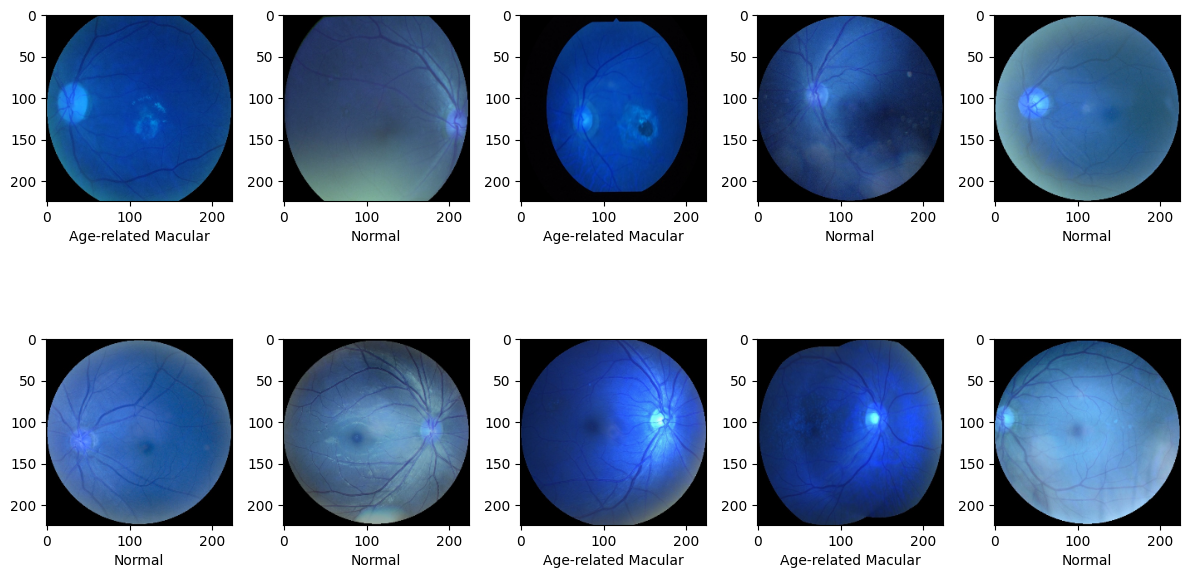

In [17]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(dataset)))
    image = dataset[sample][0]
    category = dataset[sample][1]
    if category== 0:
        label = "Normal"
    else:
        label = "Age-related Macular"
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel(label)
plt.tight_layout()    

##### Dividing dataset into x (features) & y (target)

In [18]:
x = np.array([i[0] for i in dataset]).reshape(-1,image_size,image_size,3)
y = np.array([i[1] for i in dataset])

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)

### Step 5: Creating Model

In [19]:
from tensorflow.keras.applications.vgg19 import VGG19
vgg = VGG19(weights="imagenet",include_top = False,input_shape=(image_size,image_size,3))

In [20]:
for layer in vgg.layers:
    layer.trainable = False

In [21]:
model = Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dense(1,activation="sigmoid"))

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1)                 25089     
                                                                 
Total params: 20049473 (76.48 MB)
Trainable params: 25089 (98.00 KB)
Non-trainable params: 20024384 (76.39 MB)
_________________________________________________________________


In [23]:
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

##### Early stopping for statistical optimization

In [24]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

In [25]:
checkpoint = ModelCheckpoint("vgg19.h5",monitor="val_acc",verbose=1,save_best_only=True,
                             save_weights_only=False,period=1)
earlystop = EarlyStopping(monitor="val_acc",patience=5,verbose=1)

In [27]:
history = model.fit(x_train,y_train,batch_size=32,epochs=15,validation_data=(x_test,y_test),
                    verbose=1,callbacks=[checkpoint,earlystop])

Epoch 1/15
42/42 [==============================] - 306s 7s/step - loss: 3.1526e-04 - accuracy: 1.0000 - val_loss: 0.3645 - val_accuracy: 0.9305
Epoch 2/15
42/42 [==============================] - 305s 7s/step - loss: 2.5796e-04 - accuracy: 1.0000 - val_loss: 0.3642 - val_accuracy: 0.9305
Epoch 3/15
42/42 [==============================] - 320s 8s/step - loss: 2.2271e-04 - accuracy: 1.0000 - val_loss: 0.3654 - val_accuracy: 0.9305
Epoch 4/15
42/42 [==============================] - 308s 7s/step - loss: 1.9548e-04 - accuracy: 1.0000 - val_loss: 0.3763 - val_accuracy: 0.9305
Epoch 5/15
42/42 [==============================] - 312s 7s/step - loss: 1.8096e-04 - accuracy: 1.0000 - val_loss: 0.3665 - val_accuracy: 0.9305
Epoch 6/15
42/42 [==============================] - 328s 8s/step - loss: 1.6840e-04 - accuracy: 1.0000 - val_loss: 0.3642 - val_accuracy: 0.9305
Epoch 7/15
42/42 [==============================] - 310s 7s/step - loss: 1.5534e-04 - accuracy: 1.0000 - val_loss: 0.3798 - val_ac

In [28]:
loss,accuracy = model.evaluate(x_test,y_test)
print("loss:",loss)
print("Accuracy:",accuracy)

11/11 [==============================] - 59s 5s/step - loss: 0.3670 - accuracy: 0.9245
loss: 0.36699092388153076
Accuracy: 0.9244713187217712


In [29]:
pred_y=model.predict(x_test)
y_pred=(pred_y > 0.5).astype("int32")

11/11 [==============================] - 60s 5s/step


In [30]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.9244712990936556

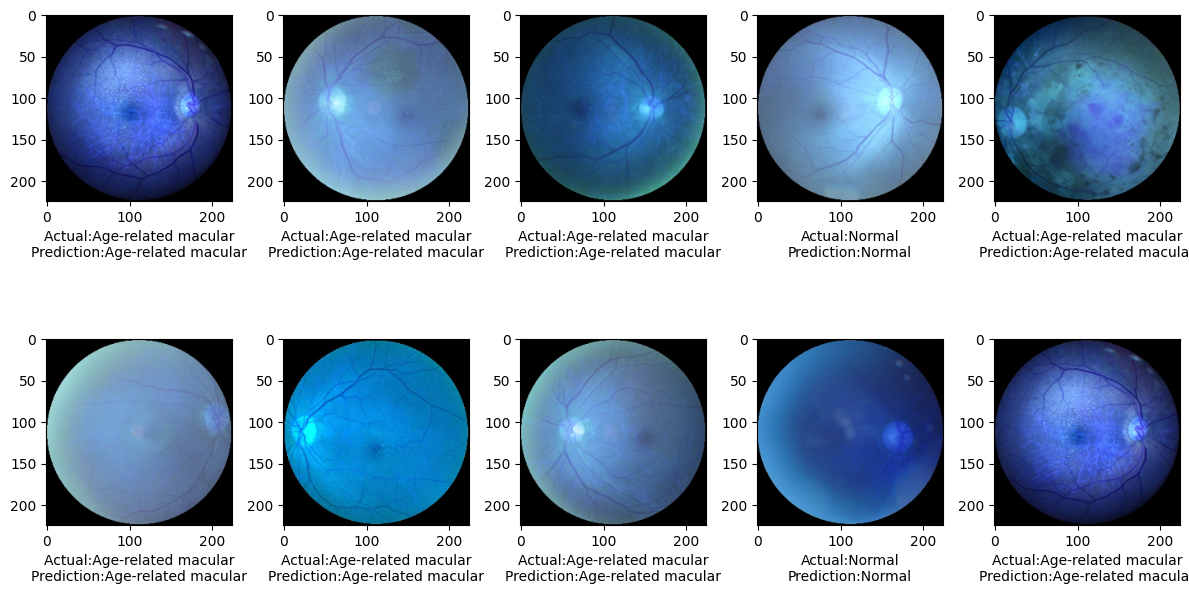

In [31]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(x_test)))
    image = x_test[sample]
    category = y_test[sample]
    pred_category = y_pred[sample]
    
    if category== 0:
        label = "Normal"
    else:
        label = "Age-related macular"
        
    if pred_category== 0:
        pred_label = "Normal"
    else:
        pred_label = "Age-related macular"
        
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel("Actual:{}\nPrediction:{}".format(label,pred_label))

plt.tight_layout() 

In [32]:
model.save('C:/Users/rocky/OneDrive/Desktop/Ocular-Disease-Recognition/models/age_macular_model.h5')

c:\Users\rocky\OneDrive\Desktop\Ocular-Disease-Recognition\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
